In [31]:
import torch
import os
import numpy as np
import scipy
from scipy.io import wavfile
import librosa
from librosa.feature import melspectrogram
from librosa.feature.inverse import mel_to_audio
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


from src.train import train
from src.NSynthDataset import NSynthDataset
from src.utils import estimate_pitch, display_audio_sample, hz_to_midi, clean
from src.WaveGAN import WaveGANGenerator
import noisereduce as nr
from tqdm import tqdm

In [2]:
batch_size = 50
z_size = 1000

# min len =16000
sr = 8191
duration = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
os.chdir('../../..')
path = 'mnt/data/public/NSynth/'

In [4]:
train_set = NSynthDataset(data_path=path,  pitched_z=True, 
                          sampling_rate=sr, duration=duration, 
                          min_class_count=10000, max_class_count=3000,
                          z_size=z_size)

In [5]:
test_set = NSynthDataset(data_path=path,
                          stage='test', pitched_z=True, 
                          sampling_rate=sr, duration=duration, 
                          cond_classes=train_set.cond_classes,
                          return_pitch=True,
                          z_size=z_size)

In [6]:
gen = WaveGANGenerator(z_size, train_set.label_size, train_set.y_size, sr=sr, duration=duration).to(device)

gen.load_state_dict(torch.load(f'users/adcy353/GANs-Conditional-Audio-Synthesis/models/wavegan/G_0.0001-1-876.pt'))
gen.eval()

WaveGANGenerator(
  (fc): Linear(in_features=1006, out_features=16384, bias=True)
  (deconv): Sequential(
    (0): ConvTranspose1d(1024, 512, kernel_size=(25,), stride=(4,), padding=(11,), output_padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(512, 256, kernel_size=(25,), stride=(4,), padding=(11,), output_padding=(1,))
    (3): ReLU()
    (4): ConvTranspose1d(256, 128, kernel_size=(25,), stride=(4,), padding=(11,), output_padding=(1,))
    (5): ReLU()
    (6): ConvTranspose1d(128, 64, kernel_size=(25,), stride=(4,), padding=(11,), output_padding=(1,))
    (7): ReLU()
    (8): ConvTranspose1d(64, 1, kernel_size=(25,), stride=(4,), padding=(11,), output_padding=(1,))
    (9): Tanh()
  )
)

In [7]:
def display_spec(specs):
    fig, axs = plt.subplots(1, len(specs), figsize=(10, 3))
    for i in range(len(specs)):
        librosa.display.specshow(librosa.power_to_db(specs[i], ref=np.max),  y_axis='mel', x_axis='time', ax=axs[i], cmap='magma')
        axs[i].set_title('Mel Spectrogram')
    plt.show()    


bass_synthetic 49 C♯


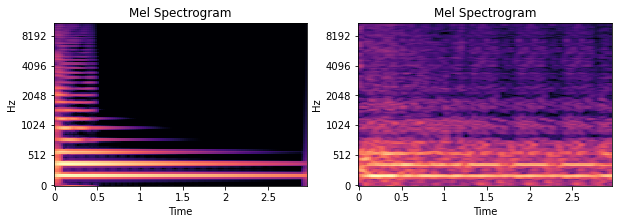

61.84176977579946 D

organ_electronic 63 D♯


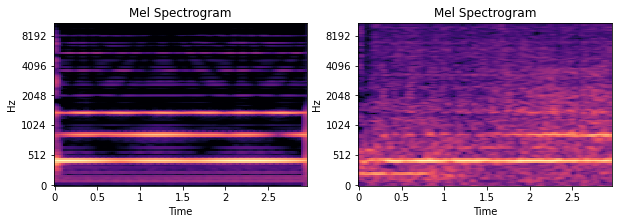

63.05604621246403 D♯

string_acoustic 46 A♯


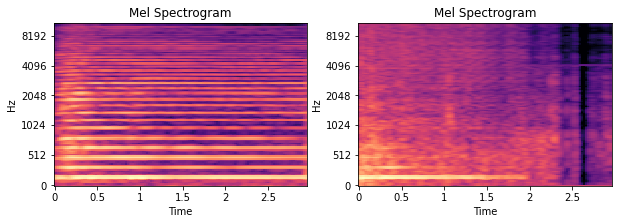

95.8114954042252 C

bass_synthetic 79 G


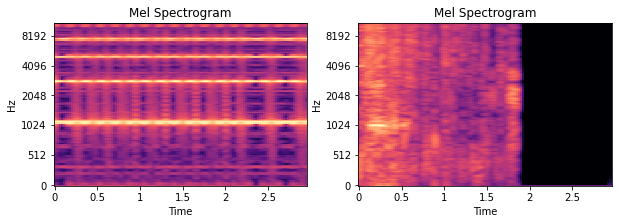

60.33162056516807 C

organ_electronic 67 G


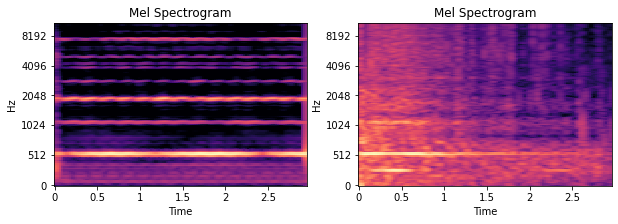

66.88991009274152 G

bass_synthetic 76 E


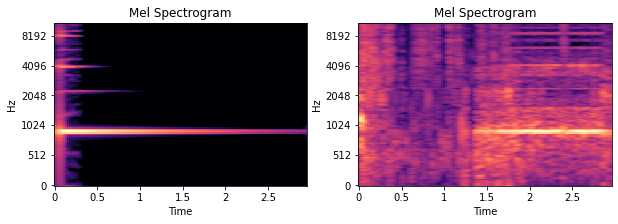

75.02082251591617 D♯

bass_synthetic 78 F♯


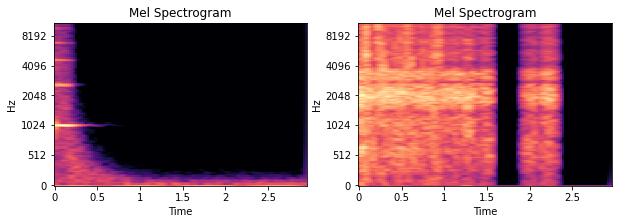

64.58564240720452 F

keyboard_electronic 69 A


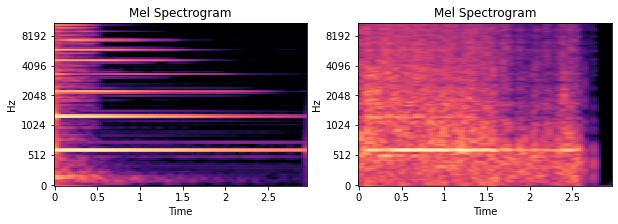

68.85362288871471 A

organ_electronic 69 A


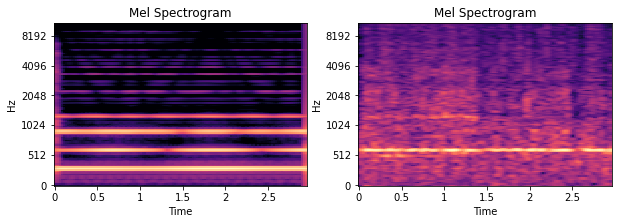

68.95360773700884 A


In [8]:
s_i = []
for i in range(0, 900, 100):
    w, l, z, pitch = test_set.__getitem__(i)
    inst = test_set.annot.loc[test_set.fnames[i], 'instrument_class_str']
    
    print(f'\n{inst} {pitch.item()} {librosa.midi_to_note(pitch, octave=False)[0]}')
    s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
    s.to(torch.device('cpu'))
    s = s.detach().cpu()
    #s = np.array(s)
    #sc = clean(s, sr)
    #reduced_noise = nr.reduce_noise(y=np.array(s), sr=sr, prop_decrease=1, n_fft=1024, hop_length=128)

    
    w_mel = librosa.feature.melspectrogram(y=np.array(w), sr=sr, n_fft=1024, hop_length=128, n_mels=128)
    s_mel = librosa.feature.melspectrogram(y=np.array(s), sr=sr, n_fft=1024, hop_length=128, n_mels=128)
    #sc_mel = librosa.feature.melspectrogram(y=np.array(reduced_noise), sr=sr, n_fft=1024, hop_length=128, n_mels=128)

    display_spec((w_mel, s_mel))#, sc_mel))
    
    display(Audio(w, rate=sr))
    display(Audio(s, rate=sr))
    #display(Audio(reduced_noise, rate=sr))
    pitch, f0 = estimate_pitch(s, sr)
    print(pitch, librosa.midi_to_note(pitch, octave=False)) 

In [9]:
test_set.__len__()

1202

## Outputs sample

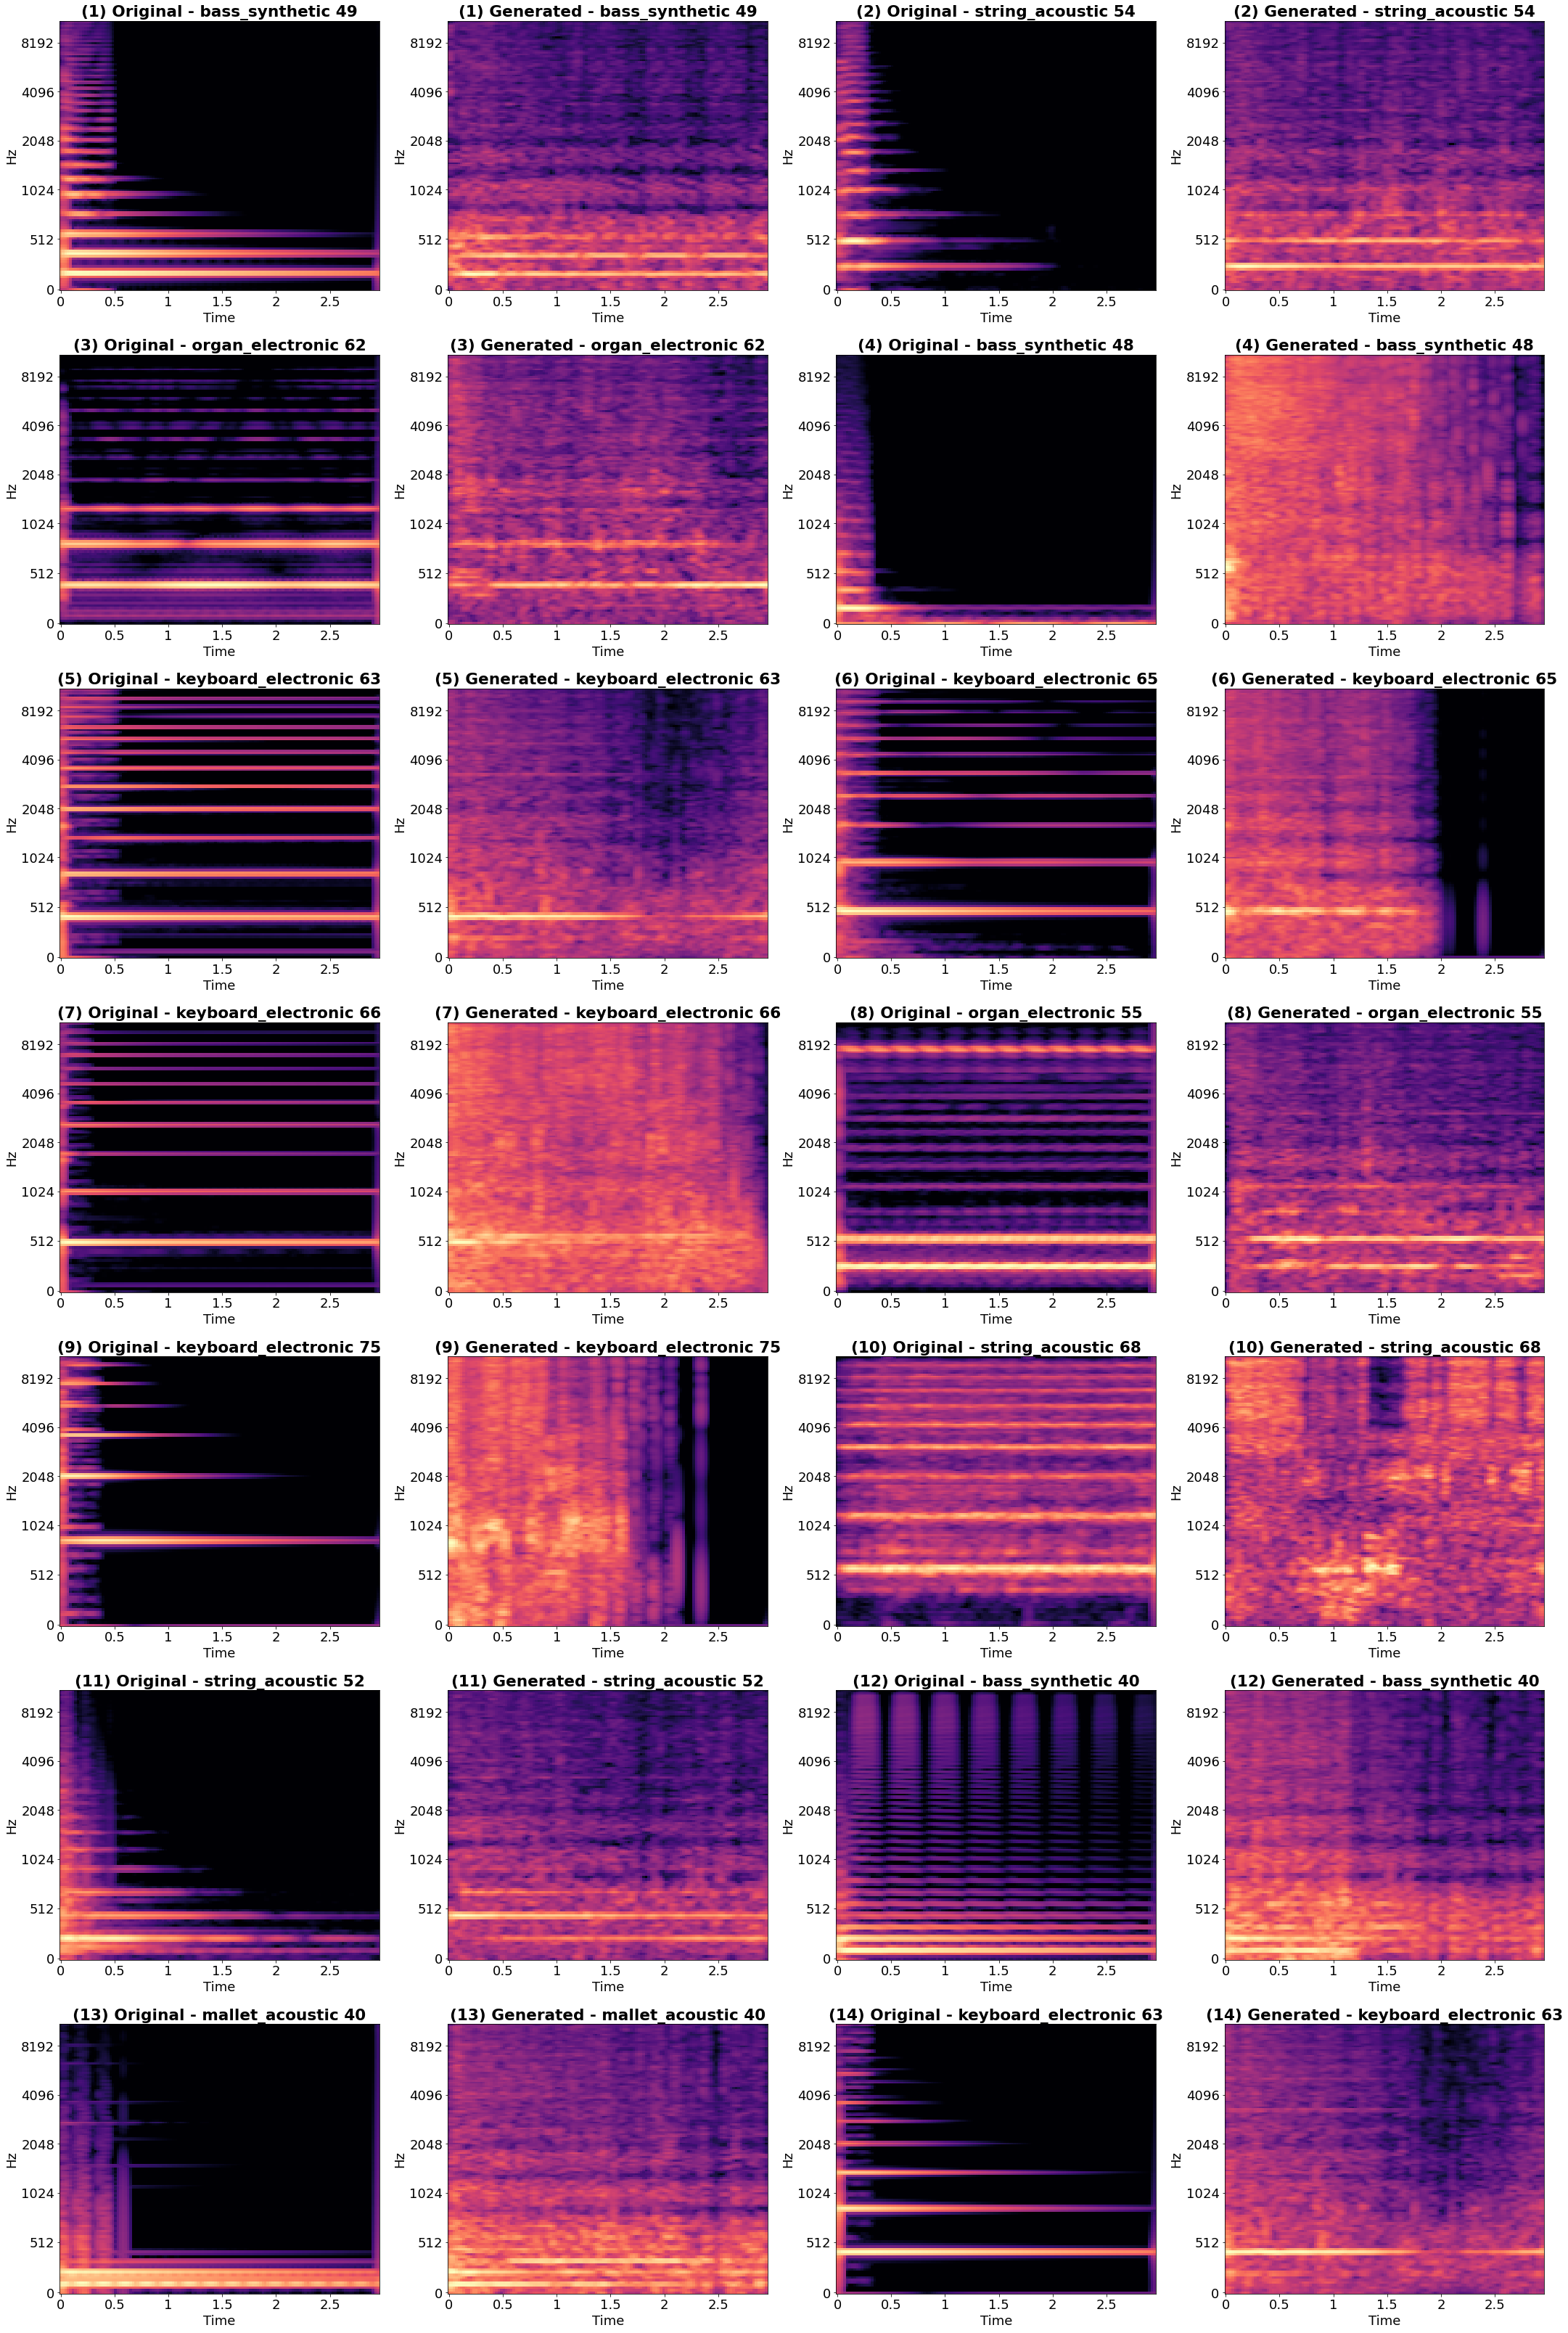

In [33]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(7, 4, figsize=(30, 45))
for a, i in enumerate(range(0, 1200, 86)):
    w, l, z, pitch = test_set.__getitem__(i)
    inst = test_set.annot.loc[test_set.fnames[i], 'instrument_class_str']
    
    label = f'{inst} {pitch.item()}'
    orig_label = f'({a+1}) Original - {label}'
    gen_label = f'({a+1}) Generated - {label}'
    
    s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
    s.to(torch.device('cpu'))
    s = s.detach().cpu()
    
    w_mel = librosa.feature.melspectrogram(y=np.array(w), sr=sr, n_fft=1024, hop_length=128, n_mels=128)
    s_mel = librosa.feature.melspectrogram(y=np.array(s), sr=sr, n_fft=1024, hop_length=128, n_mels=128)
    librosa.display.specshow(librosa.power_to_db(w_mel, ref=np.max),  y_axis='mel', x_axis='time', ax=ax.flatten()[2*a], cmap='magma')
    librosa.display.specshow(librosa.power_to_db(s_mel, ref=np.max),  y_axis='mel', x_axis='time', ax=ax.flatten()[2*a+1], cmap='magma')
    ax.flatten()[2*a].set_title(orig_label, fontdict={'fontsize':'large', 'weight':'bold'})
    ax.flatten()[2*a+1].set_title(gen_label, fontdict={'fontsize':'large', 'weight':'bold'})
    fig.tight_layout() 
    
    folder = 'users/adcy353/GANs-Conditional-Audio-Synthesis/results/wave/'
    wavfile.write(f'{folder}{orig_label}.wav', sr, np.array(w).astype(np.float32))
    wavfile.write(f'{folder}{gen_label}.wav', sr, np.array(s).astype(np.float32))


In [ ]:
testloader = DataLoader(test_set, test_set.__len__(), shuffle=False)

In [ ]:
pitches_diff = []
est_pitch = []
real_pitch = []
for data in tqdm(testloader, leave=True):
    x, l, z, p = data
    gen.eval()
    s = gen(z.to(device), l.to(device))
    reduced_noise = nr.reduce_noise(y=np.array(s.detach().cpu()), sr=sr, prop_decrease=1, n_fft=1024, hop_length=128)
    p_est = torch.tensor([estimate_pitch(row, sr)[0] for row in s.detach().cpu()]).unsqueeze(1)
    est_pitch.append(p_est)
    pitch_diff = abs(p_est - p)
    pitches_diff.append(pitch_diff)
    real_pitch.append(p)

## Pitch diff

In [ ]:
diffs = torch.cat(pitches_diff, dim=0)
diffs.mean().item(), diffs.median().item()

In [ ]:
x = range(int(diffs.max()) + 1)
y1 = [(diffs <= thresh).sum().round() for thresh in x]
plt.bar(x, y1)

In [ ]:
y2 = [(diffs.round() == t).sum().item() for t in x]
colors = [0 for _ in x]
for t in range(len(colors)):
    if t % 12 == 0:
        colors[t] = '12 semitone error'
    elif t % 7 == 0:
        colors[t] = '7 semitone error'
    else:
        colors[t] = 'Other semitone error'

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[1].bar(x, y1, color='plum')
ax[1].set_title('Pitch error (cumulative)')
ax[1].set_xlabel('n° of semitones')
ax[1].set_ylabel('count')
ax[1].set_xlim(-2, 55)

df = pd.DataFrame((zip(x, y2, colors)), columns=['x', 'y', 'hue'])
sns.barplot(df, x='x', y='y', hue='hue', ax=ax[0], palette=['purple', 'm', 'plum'], dodge=False, hue_order=['12 semitone error', '7 semitone error', 'Other semitone error'])
ax[0].set_title('Pitch error')
ax[0].set_xlabel('n° of semitones')
ax[0].set_ylabel('Count')
ax[0].set_xticks(list(range(0, 55, 10)))
ax[0].set_xlim(-2, 55)
ax[0].legend(loc='upper right')


## Pitch accuracy

In [ ]:
estimated_pitch = torch.cat(est_pitch).round()
real_pitch = torch.cat(real_pitch)

In [ ]:
(estimated_pitch == real_pitch).sum() / estimated_pitch.shape[0]

## Note accuracy

In [ ]:

estimated_notes = np.array([librosa.midi_to_note(pitch, octave=False).item() for pitch in estimated_pitch])
real_notes = np.array([librosa.midi_to_note(pitch, octave=False).item() for pitch in real_pitch])
acc = accuracy_score(real_notes, estimated_notes)
labels = sorted(np.unique(real_notes))
cm = confusion_matrix(real_notes, estimated_notes, labels=labels)
print(f'Accuracy = {acc}')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(cm, square=True, xticklabels=labels, yticklabels=labels)

In [ ]:

fig, axs = plt.subplots(1, len(specs), figsize=(10, 6))

for i in range(0, 900, 100):
    w, l, z, pitch = test_set.__getitem__(i)
    inst = test_set.annot.loc[test_set.fnames[i], 'instrument_class_str']
    
    print(f'\n{inst} {pitch.item()} {librosa.midi_to_note(pitch, octave=False)[0]}')
    s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
    s.to(torch.device('cpu'))
    s = s.detach().cpu()
    
    w_mel = librosa.feature.melspectrogram(y=np.array(w), sr=sr, n_fft=1024, hop_length=128, n_mels=128)
    s_mel = librosa.feature.melspectrogram(y=np.array(s), sr=sr, n_fft=1024, hop_length=128, n_mels=128)
    
    librosa.display.specshow(librosa.power_to_db(specs[i], ref=np.max),  y_axis='mel', x_axis='time', ax=axs[i], cmap='magma')
        axs[i].set_title('Mel Spectrogram')
    
    display(Audio(w, rate=sr))
    display(Audio(s, rate=sr))
    #display(Audio(reduced_noise, rate=sr))
    pitch, f0 = estimate_pitch(s, sr)
    print(pitch, librosa.midi_to_note(pitch, octave=False)) 

In [14]:
Audio(w, rate=sr)

NameError: name 'w' is not defined

In [24]:
z_rd = 2 * torch.rand(z_size) - 1
z_noise = z.clone() + z_rd

Text(0.5, 1.0, 'Resulting generator input')

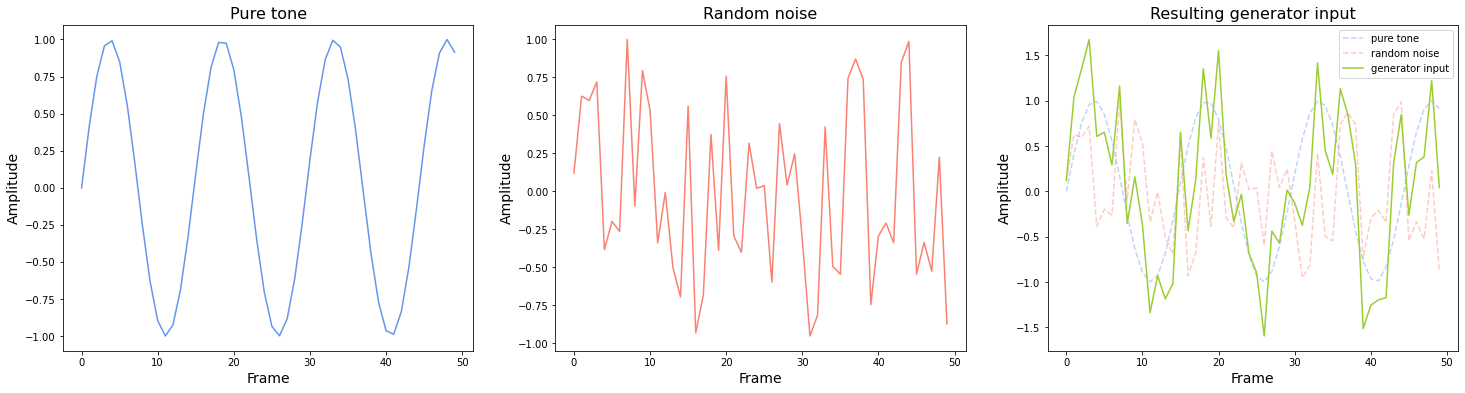

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
ax[0].plot(z[:50], c='cornflowerblue')
ax[1].plot(z_rd[:50], c='salmon')
#ax[2].plot(z_noise[:50], c='yellowgreen')

ax[2].plot(z[:50], 'g--', c='cornflowerblue', alpha=0.4, label='pure tone')
ax[2].plot(z_rd[:50], 'g--', c='salmon', alpha=0.4, label='random noise')
ax[2].plot(z_noise[:50], c='yellowgreen', label='generator input')
ax[2].legend()
           
for a in ax:
    a.set_xlabel('Frame', fontdict={'fontsize': 14})
    a.set_ylabel('Amplitude', fontdict={'fontsize': 14})

ax[0].set_title('Pure tone', fontdict={'fontsize': 16})
ax[1].set_title('Random noise', fontdict={'fontsize': 16})
ax[2].set_title('Resulting generator input', fontdict={'fontsize': 16})
#ax[3].set_title('Generator input')

#fig.title('pitched_input.png')
#fig.savefig('/Users/elisa/Desktop/Thesis/img/pitched_input.png')